In [ ]:
!pip install lightfm
import numpy as np
import pandas as pd
import tqdm
import re
from lightfm import LightFM
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

books_ratings = pd.read_csv('/content/drive/MyDrive/data8/BX-Book-Ratings.csv', encoding = "ISO-8859-1" ,sep=';')
books = pd.read_csv('/content/drive/MyDrive/data8/BX-Books.csv', encoding = "ISO-8859-1" , sep=',')
users = pd.read_csv('/content/drive/MyDrive/data8/BX-Users.csv', encoding = "ISO-8859-1" ,sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#books_ratings.head()
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
users.shape

(278858, 3)

In [ ]:
books_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
books_ratings.shape

(1149780, 3)

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


## Персональный топ



### Будем учитывать только страну и возраст +- 5 лет
### На основе этого выводить наши предложения

In [ ]:

class Top():
    def __init__(self, users, books_ratings, books):
        self.books_ISBN_to_url = {}
        for i in books[["ISBN", "Image-URL-L"]].drop_duplicates().values:
            self.books_ISBN_to_url[i[0]] = i[1]
        gg = users.merge(books_ratings[["User-ID", "ISBN", "Book-Rating"]].drop_duplicates(), on=["User-ID"])
        ff = gg.merge(books[["ISBN", "Book-Title"]].drop_duplicates(), on=["ISBN"])
        
        ff["Location"] = ff.Location.str.split(',').apply(lambda x: x[-1][1:])

        self.interactions = ff
        #print(self.interactions["Location"])

    def top_books(self, age, location):
        #books = self.interactions[age-5 <= self.interactions["Age"]][self.interactions["Age"] <= age+5][self.interactions["Location"] == " usa"]
        #print(books)
        books = self.interactions[age-5 <= self.interactions["Age"]][self.interactions["Age"] <= age+5][self.interactions["Location"] == location]\
        .groupby(["ISBN", "Book-Title"])["Book-Rating"].mean().reset_index().sort_values("Book-Rating", ascending=False)[:5]
        #print(books)
        #rec_imaging(books["ISBN"].values, self.books_ISBN_to_url, books["Book-Rating"].values)
        for i in str(books["Book-Title"]).split('\n'):
            print(' '.join(i.split()[1:]))

In [ ]:
T = Top(users, books_ratings, books)

In [ ]:
T.top_books(20, 'usa')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Dune Messiah
The Dictionary of Cultural Literacy
Simply Handmade: 365 Easy Gifts &amp; Decorati...
Unbuilding
Portable Dorothy Parker (Viking Portable Library)
Book-Title, dtype: object


## Рекомендации на основе похожих пользователей 

### Сначала отберём пользователей, которые оставили хотя бы 2 отзыва

In [ ]:
users_dict = {}
norm_users = {}
books_ratings['my_data'] = books_ratings[['User-ID', 'ISBN']].apply(tuple, axis=1)
for i in books_ratings["my_data"]:
    if i[0] in users_dict: 
        if i[0] in norm_users:
            norm_users[i[0]].append(i[1])
        else:
            norm_users[i[0]] = [users_dict[i[0]], i[1]]
    else:
        users_dict[i[0]] = i[1]


### Посмотрим их распределение

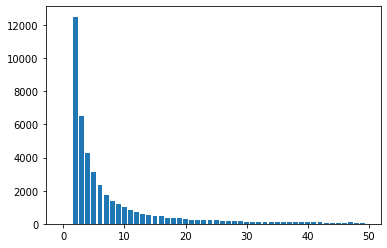

In [ ]:
B = []
d = 50
for i in range(d):
    B.append(i)
A = [0]*d
#print(len(A))

for i in norm_users.items():
    if len(i[1]) < d:
        A[len(i[1])] += 1

#plt.subplot(132)
plt.bar(B, A)
plt.show()

### Поймём, что нам не интересны пользователи, у которых 10+ отзывов или всего 2
### Будем добавлять в один класс книги всех авторов, у которых пересекаются хотя бы 3 отзыва

In [ ]:
from tqdm.notebook import tqdm as tq
class_by_users = {}
B = []

for i in tq(norm_users.items()):
    A = i[1]
    qq = len(A)
    if len(A) > 10 or len(A) == 2:
        continue
    for j in norm_users.items():
        if len(j[1]) > 10 or len(j[1]) == 2:
            continue
        if i != j:
            o = 0
            for k in j[1]:
                if k in A:
                    o += 1
                    if o == 3:
                        for p in j[1]:
                            A.append(p)
                        break
        
    #A.sort()
    if len(A) > qq:
        print(1)
        B.append(A)    

### Далее в каждом классе, каждой книге выдадим среднее на основе всех оценок из общей таблицы

In [ ]:
print(len(B)) ## Количество классов, которые я выделил
G = []
count = 0
for i in tq(B):
    po = []
    for j in i:
        
        srednee = books_ratings[books_ratings["ISBN"] == j]["Book-Rating"].mean()
        h = [j, srednee]
        
        po.append(h)
    G.append(po)
    count += 1
    if count == 10:
        pass
        #break


460


### После чего отсортируем и выведем топ-10 книг из класса

In [ ]:
def top(num):
    if num >= len(G):
        return -1
    i = G[num]
    #print(i)
    i = (sorted(i, key=lambda x : x[1], reverse=True))
    kk = []
    for l in i:
        if l not in kk:
            kk.append(l)
    #print(kk)
    for j in range(min(10, len(kk))):
        #print(books[books["ISBN"] == kk[j][0]]["Book-Title"], kk[j][1])
        print(' '.join(str(books[books["ISBN"] == kk[j][0]]["Book-Title"]).split('Name: Book-Title, dtype: object')[0].split()[1:]), kk[j][1])

In [ ]:
print(top(2)) # 0..419 

Reflections: Life After the White House 8.0
Kushiel's Chosen (Kushiel's Legacy) 7.285714285714286
Kushiel's Avatar (Kushiel's Legacy) 6.142857142857143
Daughter of the Blood (Black Jewels Trilogy) 5.470588235294118
Queen of the Darkness (Black Jewels Trilogy) 4.947368421052632
Kushiel's Dart 3.6166666666666667
The Claiming of Sleeping Beauty (Sleeping Beauty) 3.6
Heir to the Shadows (The Black Jewels Trilogy,... 3.2777777777777777
Beauty's Release 1.7045454545454546
He Sees You When You're Sleeping : A Novel 1.676056338028169
None


## Совстречаемость


### Уберём всё лишнее и выведу для каждой книги похожие произведения

In [83]:
from tqdm.notebook import tqdm as tq
class Recomendations():
    def __init__(self, users, books_ratings, books):
        self.books_ISBN_to_url = {}
        for i in books[["ISBN", "Image-URL-L"]].drop_duplicates().values:
            self.books_ISBN_to_url[i[0]] = i[1]
        self.books_ISBN_to_title = {}
        for i in books[["ISBN", "Book-Title"]].drop_duplicates().values:
            self.books_ISBN_to_title[i[0]] = i[1]
        gg = users.merge(books_ratings[["User-ID", "ISBN", "Book-Rating"]], on=["User-ID"])
        ff = gg.merge(books[["ISBN", "Book-Title"]].drop_duplicates(), on=["ISBN"])

        self.interactions = ff
        
    def coocurrency_count(self):
        rating = self.interactions[["User-ID", "ISBN"]]
        user_ratings = rating.groupby(["User-ID"])["ISBN"].apply(list).reset_index()
        
        rating_num = [len(i) for i in user_ratings["ISBN"]]
        user_ratings["rating_num"] = rating_num
        user_ratings = user_ratings[user_ratings["rating_num"] > 1][user_ratings["rating_num"] < 12]
        #print("I'm here")
        cooc = {}
        print(len(user_ratings.values))
        for i in tq(user_ratings.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += 1
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
        cooc_list = []
        for i, j in cooc.items():
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["book1", "book2", "measure"])
    
    def get_rec(self, u):

        books_id_to_ISBN = {}
        fff = books[["ISBN"]].drop_duplicates().values
        #print(fff)
        for i in range(len(fff)):
            books_id_to_ISBN[i] = fff[i]
        i = books_id_to_ISBN[u][0]
        #print(self.cooc_rec.head(10))
        recs = self.cooc_rec[self.cooc_rec["book1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print("Для Книги")
        print(self.books_ISBN_to_title[str(i)])
        print(u"Такие рекомендации")
        
        for i in recs[["book2", "measure"]].drop_duplicates().values:
            print(self.books_ISBN_to_title[str(i[0])], i[1])

        

In [84]:
T = Recomendations(users, books_ratings, books)

In [85]:
T.coocurrency_count()

30745


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [86]:
T.get_rec(52)

Для Книги
The Street Lawyer
Такие рекомендации
The Runaway Jury 6
The Partner 6
The Chamber 5
The Brethren 5
The Rainmaker 4
The Client 3
Remember Me 3
The Pelican Brief 3
The Testament 3
A Time to Kill 2
